#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.


### Chapter 24
**CH24A Estimating the effect of the 2010 Haiti earthquake on GDP**

using the `haiti-earthquake` dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
from plotnine import *

warnings.filterwarnings("ignore")
# turning off scientific notation
pd.set_option("display.float_format", lambda x: "%.3f" % x)


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/haiti-earthquake/clean/"
data_out = dirname + "da_case_studies/ch24-haiti-earthquake-gdp/"
output = dirname + "da_case_studies/ch24-haiti-earthquake-gdp/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


In [4]:
data = pd.read_stata(data_in + "haiti-earthquake-mod.dta")


In [5]:
dp_countries = [
    "Benin",
    "Burkina Faso",
    "Burundi",
    "Bangladesh",
    "Cambodia",
    "Cameroon",
    "Kenya",
    "Kyrgyz Republic",
    "Liberia",
    "Madagascar",
    "Mali",
    "Moldova",
    "Mozambique",
    "Nicaragua",
    "Nepal",
    "Rwanda",
    "Senegal",
    "Sierra Leone",
    "Sudan",
    "Tanzania",
    "Togo",
    "Uganda",
    "Haiti",
]


In [6]:
data = data.loc[lambda x: x["country"].isin(dp_countries)]


In [7]:
haiti = data.loc[lambda x: x["country"] == "Haiti", ["year", "gdptb_us"]].reset_index(
    drop=True
)


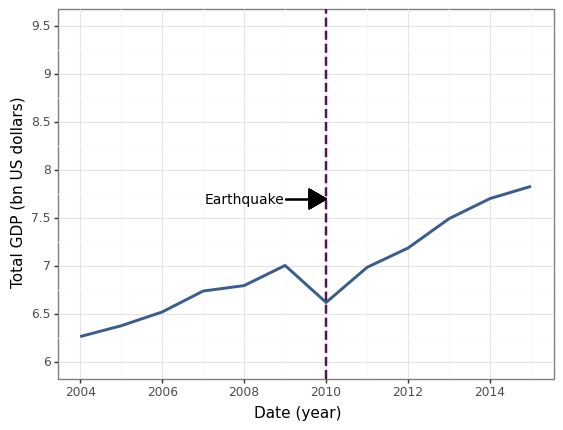

<ggplot: (393632452)>

In [8]:
(
    ggplot(haiti, aes(x="year", y="gdptb_us"))
    + geom_line(color=color[0], size=1.2)
    + geom_vline(xintercept=2010, color=color[2], size=1, linetype="dashed")
    + labs(y="Total GDP (bn US dollars)", x="Date (year)")
    + scale_y_continuous(breaks=seq(6, 9.6, 0.5), limits=(6, 9.5))
    + scale_x_continuous(breaks=seq(2004, 2015, 2), limits=(2004, 2015))
    + geom_segment(
        aes(x=2009, y=7.7, xend=2010, yend=7.7), arrow=arrow(type="closed", ends="last")
    )
    + annotate("text", x=2008, y=7.7, label="Earthquake", size=10)
    + theme_bw()
)


**NOTE:** To install the [SyntheticControlMethods](https://github.com/OscarEngelbrektson/SyntheticControlMethods) package, you have to have CMake installed on your computer (at least for Mac OS, we needed it). Follow the instructions on the CMake [website](https://cmake.org/)

**NOTE:** Verified versions of Python that works with [SyntheticControlMethods](https://github.com/OscarEngelbrektson/SyntheticControlMethods): 3.8

In [9]:
from SyntheticControlMethods import Synth


In [10]:
data = data.filter(
    [
        "country",
        "year",
        "gdptb_us",
        "cons",
        "exp",
        "imp",
        "gcf",
        "land",
        "pop",
        "inf",
        "gdppc_w",
    ]
)

In [11]:
sc = Synth(
    data,
    "gdptb_us",
    "country",
    "year",
    2010,
    "Haiti",
    pen=22,
    n_optim=200,
    random_seed=210,
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53666D+01    |proj g|=  8.88889D-01

At iterate    3    f=  5.13936D+00    |proj g|=  8.89038D-01

At iterate    6    f=  4.06894D+00    |proj g|=  8.89037D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      8     64     16     0     0   8.890D-01   4.069D+00
  F =   4.0687476769311486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      9     65     26     1     7   1.729D-01   6.609D-01
  F =  0.66092910456341891     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.22311D+02    |proj g|=  9.93735D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      0      1      0     0     0   0.000D+00   4.727D+04
  F =   47266.222655519479     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.3

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74704D+01    |proj g|=  9.81500D-01

At iterate    3    f=  5.29346D-01    |proj g|=  1.12076D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      4      6     12     0     0   1.341D-04   5.293D-01
  F =  0.52934572240045941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 v


At iterate    3    f=  2.82661D-01    |proj g|=  9.64901D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     23     11     0     0   1.660D-02   2.827D-01
  F =  0.28266087803803824     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55654D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      0      1      0     0     0   0.000D+00   1.557D+01
  F =   15.565420677019086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5      7     11     0     0   6.032D-04   2.827D-01
  F =  0.28266087803031686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-4.287E-07  -gs= 2.186E-06 BFGS update SKIPPED

At iterate   15    f=  9.29195D-02    |proj g|=  2.40720D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     15    115     32     2     5   2.407D-01   9.292D-02
  F =   9.2919488178777460E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32392D+03    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of fu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    3    f=  1.97837D-01    |proj g|=  4.73324D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      4      7     12     0     0   4.128D-02   1.978D-01
  F =  0.19783743114785976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     21     13     0     0   2.864D-03   2.186D-01
  F =  0.21858555203911612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19812D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      0      1      0     0     0   0.000D+00   1.198D+01
  F =   11.981182389386033     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.7

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      0      1      0     0     0   0.000D+00   4.727D+04
  F =   47266.222655746817     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.7


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      4     19     12     0     0   1.153D-02   1.978D-01
  F =  0.19783743101040546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      0      1      0     0     0   0.000D+00   4.727D+04
  F =   47266.222655739504     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.7

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66490D+02    |proj g|=  9.95187D-01
  ys=-1.865E+01  -gs= 5.709E+01 BFGS update SKIPPED

At iterate    3    f=  1.90748D+01    |proj g|=  9.93057D-01

At iterate    6    f=  3.03554D-01    |proj g|=  1.46596D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      7     43     23     1     0   1.466D-01   3.036D-01
  F =  0.30355414889393240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1      2      9     0     9   0.000D+00   3.373D+01
  F =   33.733651222904058     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.22451D+03    |proj g|=  9.93896D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      0      1      0     0     0   0.000D+00   4.727D+04
  F =   47266.222655747551     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.7


At iterate    3    f=  2.18587D-01    |proj g|=  9.26391D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     46     12     0     0   7.142D-04   2.186D-01
  F =  0.21858555201317570     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55654D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44993D+03    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      0      1      0     0     0   0.000D+00   4.450D+03
  F =   4449.9265559639898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.4

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34220D+02    |proj g|=  9.89598D-01

At iterate    3    f=  1.46831D+00    |proj g|=  9.54199D-01

At iterate    6    f=  1.46531D+00    |proj g|=  9.54142D-01
  Positive dir derivative in projection 
  Using the backtracking step 



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      7     69     22     0     6   9.541D-01   1.465D+00
  F =   1.4653059190975779     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate    3    f=  1.52968D+01    |proj g|=  2.13163D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      3      8      5     0     0   2.132D-06   1.530D+01
  F =   15.296818195730344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01108D+00    |proj g|=  9.98600D-01

At iterate    3    f=  1.97837D-01    |proj g|=  4.08592D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu


At iterate    3    f=  9.03529D+00    |proj g|=  9.51149D-01

At iterate    6    f=  4.45435D+00    |proj g|=  9.44627D-01

At iterate    9    f=  1.69302D+00    |proj g|=  9.38495D-01

At iterate   12    f=  1.47507D+00    |proj g|=  9.37812D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     15    169     27     0     3   4.048D-01   1.475D+00
  F =   1.4750253273969058     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     15      1     0     0   1.455D-03   4.727D+04
  F =   47266.222655747595     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37890D+03    |proj g|=  9.96596D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72662D+04    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      0      1      0     0     0   0.000D+00   4.727D+04
  F =   47266.222655747581     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.3

Built-in plots for comparison

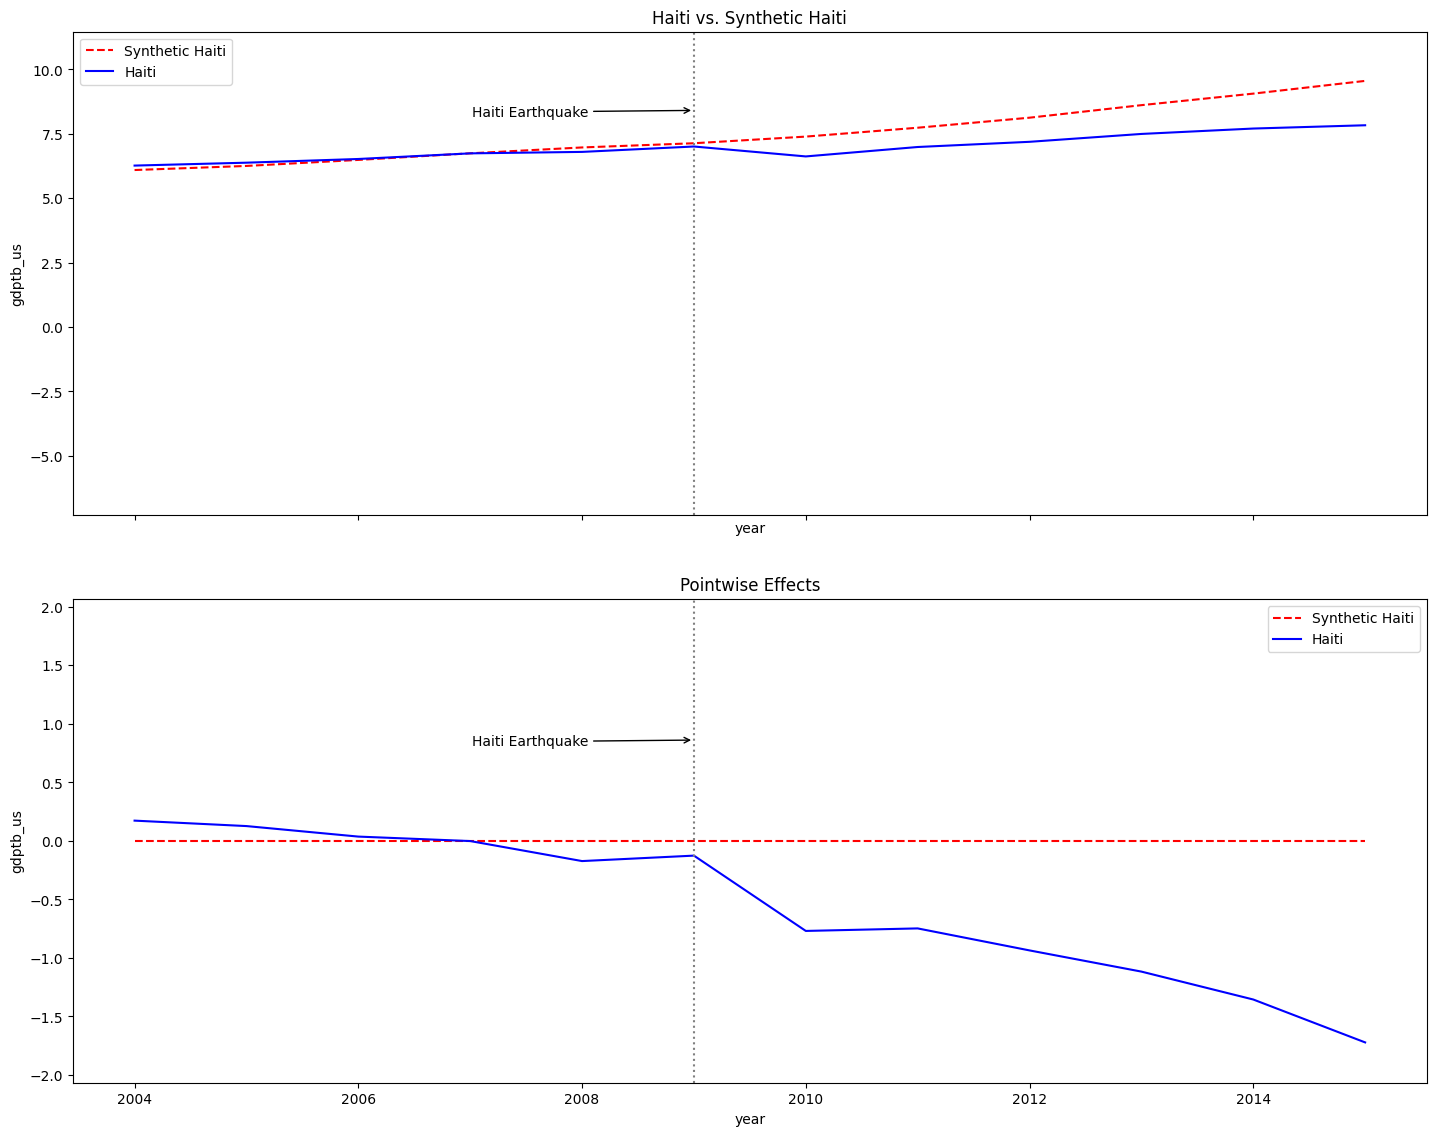

In [12]:
sc.plot(
    ["original", "pointwise"],
    treated_label="Haiti",
    synth_label="Synthetic Haiti",
    treatment_label="Haiti Earthquake",
)


Get weight matrix of solution


In [13]:
sc.original_data.weight_df


,Weight
Cameroon,0.273
Liberia,0.727


In [14]:
sc.original_data.comparison_df

,Haiti,Synthetic Haiti,WMAPE,Importance
gdptb_us,6.620,6.610,8.110,0.070
cons,100.200,184.950,93.920,0.200
exp,14.260,54.420,40.160,0.080
imp,42.950,158.680,126.790,0.090
gcf,28.490,19.320,9.170,0.060
land,27560.000,199124.530,171561.610,0.170
pop,9484519.000,7676933.420,6927419.640,0.060
inf,12.610,8.310,4.300,0.190
gdppc_w,1582.400,1159.210,954.100,0.080


**NOTE:** This algorithm results in a different weights for the Synthetic Haiti than Stata

Get synthetic outcomes for Haiti

In [15]:
haiti["Ysynthetic"] = sc.original_data.__dict__["synth_outcome"][0]
haiti["Ytreated"] = haiti["gdptb_us"]


Figure with total GDP in Haiti and synthethic control

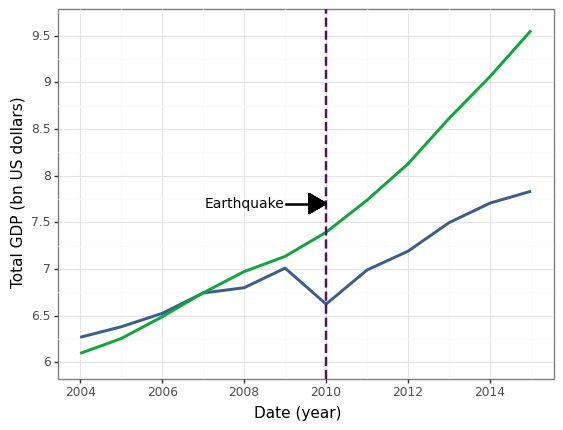

<ggplot: (396139418)>

In [16]:
(
    ggplot(haiti, aes(x="year", y="Ytreated"))
    + geom_line(color=color[0], size=1.2)
    + geom_line(aes(y="Ysynthetic"), color=color[1], size=1.2)
    + geom_vline(xintercept=2010, color=color[2], size=1, linetype="dashed")
    + labs(y="Total GDP (bn US dollars)", x="Date (year)")
    + geom_segment(
        aes(x=2009, y=7.7, xend=2010, yend=7.7), arrow=arrow(type="closed", ends="last")
    )
    + annotate("text", x=2008, y=7.7, label="Earthquake", size=10)
    + scale_y_continuous(breaks=seq(6, 9.6, 0.5), limits=(6, 9.6))
    + scale_x_continuous(breaks=seq(2004, 2015, 2), limits=(2004, 2015))
    + theme_bw()
)


 Figure with differenence in log total GDP

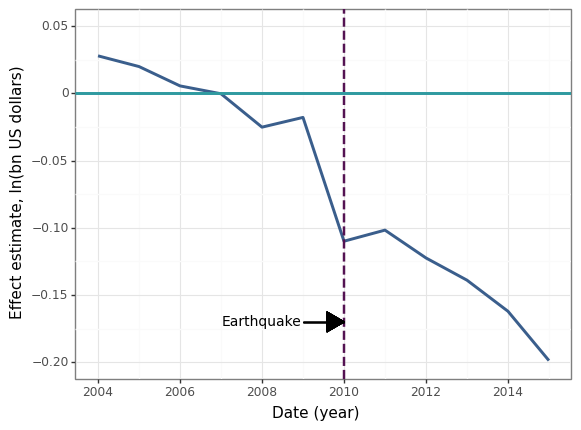

<ggplot: (396194774)>

In [17]:
(
    ggplot(haiti, aes(x="year", y="np.log(Ytreated) - np.log(Ysynthetic)"))
    + geom_line(color=color[0], size=1.2)
    + geom_vline(xintercept=2010, color=color[2], size=1, linetype="dashed")
    + geom_hline(yintercept=0, color=color[4], size=1.2)
    + labs(y="Effect estimate, ln(bn US dollars)", x="Date (year)")
    + geom_segment(
        aes(x=2009, y=-0.17, xend=2010, yend=-0.17),
        arrow=arrow(type="closed", ends="last"),
    )
    + annotate("text", x=2008, y=-0.17, label="Earthquake", size=10)
    + scale_y_continuous(breaks=seq(-0.2, 0.06, 0.05), limits=(-0.20, 0.05))
    + scale_x_continuous(breaks=seq(2004, 2015, 2), limits=(2004, 2015))
    + theme_bw()
)
